In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from collections import Counter
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
%ls data/

In [2]:
# 1. Apply k-means clustering to the combined master DF:
combined_master_df = pd.read_pickle("data/combined_info_rev_df.pkl.bz2")

In [3]:
tokenizer = RegexpTokenizer(r"\w+")
stopwords_ = set(stopwords.words("english"))

vectorizer = TfidfVectorizer(strip_accents="ascii",
                             lowercase=True,
                             tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_                            
                            )

In [4]:
combined_master_df.columns

Index(['ep_title', 'show_sea_ep', 'airdate', 'synopsis', 'IMDB_ID',
       'IMDB_user_rating', 'num_IMDB_usr_rtgs', 'season', 'episode', 'series',
       'year', 'rvr_rating', 'title_blob', 'rev_blob', 'super_blob'],
      dtype='object')

In [5]:
combined_master_df["super_blob"]

0      Capt. Pike is held prisoner and tested by alie...
1      Dr. McCoy discovers his old flame is not what ...
2      Captain Kirk must learn the limits to the powe...
3      The flight recorder of the 200-year-old U.S.S....
4      The crew is infected with a mysterious disease...
5      A transporter malfunction splits Captain Kirk ...
6      The Enterprise picks up untrustworthy entrepre...
7      Nurse Chapel is reunited with her fiancé; but ...
8      The Enterprise discovers a planet exactly like...
9      Kirk and psychiatrist Helen Noel are trapped o...
10     After the Enterprise is forced to destroy a da...
11     Spock kidnaps the crippled Capt. Pike, hijacks...
12     At Spock's court martial, he explains himself ...
13     While Captain Kirk investigates whether an act...
14     The Enterprise must decide on its response whe...
15     The past three months has left the crew of the...
16     The Galileo, under Spock's command, crash-land...
17     A being that controls ma

In [6]:
X = vectorizer.fit_transform(combined_master_df["super_blob"])

In [7]:
print(f"Shape of X: {X.shape}")
print(f"X as dense matrix: {X.todense()}")

Shape of X: (719, 35899)
X as dense matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
features = vectorizer.get_feature_names()

In [9]:
features

['0',
 '00',
 '000',
 '0001',
 '001',
 '0040',
 '0047',
 '007',
 '008',
 '00ish',
 '01',
 '01a',
 '01the',
 '02',
 '02i',
 '02with',
 '03',
 '03contrary',
 '03upgrading',
 '04',
 '04this',
 '05',
 '05not',
 '06',
 '06this',
 '07',
 '079',
 '07the',
 '08',
 '09',
 '0f',
 '0o',
 '1',
 '10',
 '100',
 '1000',
 '100s',
 '100th',
 '100x',
 '101',
 '1014',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '1074',
 '107th',
 '108',
 '1080p',
 '108th',
 '109',
 '10am',
 '10k',
 '10s',
 '10star',
 '10th',
 '11',
 '110',
 '11001001',
 '11001001a',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '11th',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '12th',
 '13',
 '130',
 '1300',
 '1305',
 '131',
 '1312',
 '132',
 '133',
 '1334',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '13th',
 '14',
 '140',
 '1408',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '14th',
 '15',
 '150',
 '1500',
 '15000',
 '150th',


In [10]:
kmeans_clusterer = KMeans(n_clusters=8,
                          n_jobs=-1
                     )

In [11]:
kmeans_clusterer.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
# 2. Show the centroids:
centroid_array = kmeans_clusterer.cluster_centers_

In [13]:
centroid_array.shape

(8, 35899)

In [14]:
centroid_array

array([[0.0005901 , 0.        , 0.00308415, ..., 0.        , 0.00021405,
        0.00027564],
       [0.00061054, 0.00010125, 0.00198065, ..., 0.00011364, 0.        ,
        0.        ],
       [0.00102454, 0.00028951, 0.00145591, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00063258, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00129501, 0.        , 0.00263356, ..., 0.        , 0.        ,
        0.        ],
       [0.00199762, 0.        , 0.00307348, ..., 0.        , 0.        ,
        0.        ]])

In [15]:
# 3. Find top 10 features for each cluster:
top_centroids = centroid_array.argsort()[:, -1:-11:-1]

In [16]:
print("Top 10 words for each cluster:\n")
for num, centroid in enumerate(top_centroids):
    print(f"Centroid {num} :",", ".join(features[i] for i in centroid),"\n")
    
    

Top 10 words for each cluster:

Centroid 0 : voyager, episode, janeway, neelix, doctor, tuvok, chakotay, kes, tom, elanna 

Centroid 1 : kirk, spock, episode, enterprise, mccoy, one, planet, trek, star, like 

Centroid 2 : picard, episode, data, enterprise, riker, one, troi, stewart, ship, star 

Centroid 3 : worf, klingon, klingons, episode, alexander, jadzia, dax, quark, one, martok 

Centroid 4 : odo, sisko, episode, kira, quark, bashir, ds9, brien, station, dominion 

Centroid 5 : pol, archer, vulcans, vulcan, enterprise, episode, trip, phlox, andorians, hoshi 

Centroid 6 : archer, enterprise, xindi, episode, trip, pol, one, phlox, hoshi, ship 

Centroid 7 : borg, seven, voyager, janeway, hirogen, episode, collective, q, chakotay, nine 



In [25]:
# 4. Limit number of features to see if the words/topics change:
vectorizer = TfidfVectorizer(strip_accents="ascii",
                             lowercase=True,
                             tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_,
                             max_features=1000
                            )

X = vectorizer.fit_transform(combined_master_df["super_blob"])
features = vectorizer.get_feature_names()

kmeans_clusterer = KMeans(n_clusters=8,
                          n_jobs=-1
                     )

kmeans_clusterer.fit(X)
centroid_array = kmeans_clusterer.cluster_centers_
top_centroids = centroid_array.argsort()[:, -1:-11:-1]

print("Top 10 words for each cluster:\n")
for num, centroid in enumerate(top_centroids):
    print(f"Centroid {num} :",", ".join(features[i] for i in centroid),"\n")

Top 10 words for each cluster:

Centroid 0 : picard, episode, data, enterprise, riker, one, worf, ship, stewart, troi 

Centroid 1 : kirk, spock, episode, enterprise, one, mccoy, planet, trek, star, like 

Centroid 2 : voyager, janeway, episode, doctor, neelix, chakotay, tuvok, crew, one, ship 

Centroid 3 : archer, pol, enterprise, episode, trip, xindi, phlox, one, ship, vulcans 

Centroid 4 : quark, ferengi, episode, odo, one, bashir, nog, jake, ds9, station 

Centroid 5 : odo, kira, episode, garak, sisko, dominion, station, quark, ds9, one 

Centroid 6 : seven, borg, voyager, janeway, episode, nine, chakotay, one, doctor, crew 

Centroid 7 : sisko, episode, kira, bashir, brien, ds9, dax, dukat, station, one 



In [26]:
# 4a. Max features but 12 topics:
vectorizer = TfidfVectorizer(strip_accents="ascii",
                             lowercase=True,
                             tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_,
                             max_features=None
                            )

X = vectorizer.fit_transform(combined_master_df["super_blob"])
features = vectorizer.get_feature_names()

kmeans_clusterer = KMeans(n_clusters=12,
                          n_jobs=-1
                     )

kmeans_clusterer.fit(X)
centroid_array = kmeans_clusterer.cluster_centers_
top_centroids = centroid_array.argsort()[:, -1:-11:-1]

print("Top 10 words for each cluster:\n")
for num, centroid in enumerate(top_centroids):
    print(f"Centroid {num} :",", ".join(features[i] for i in centroid),"\n")

Top 10 words for each cluster:

Centroid 0 : seven, voyager, borg, janeway, nine, episode, hirogen, doctor, ryan, jeri 

Centroid 1 : sisko, quark, episode, kira, dukat, brien, bashir, ds9, dax, one 

Centroid 2 : kirk, spock, episode, enterprise, mccoy, one, planet, trek, star, like 

Centroid 3 : picard, episode, data, enterprise, riker, one, ship, stewart, troi, star 

Centroid 4 : q, picard, vash, lancie, continuum, episode, de, riker, enterprise, powers 

Centroid 5 : worf, klingon, klingons, jadzia, episode, alexander, martok, kor, dax, kurn 

Centroid 6 : lwaxana, jake, troi, episode, sisko, majel, barrett, one, odo, father 

Centroid 7 : archer, pol, enterprise, episode, trip, xindi, phlox, hoshi, one, ship 

Centroid 8 : borg, voyager, janeway, seven, collective, queen, episode, drones, cube, one 

Centroid 9 : odo, hadar, garak, jem, sisko, kira, episode, dominion, quark, bashir 

Centroid 10 : doctor, voyager, picardo, episode, hologram, zimmerman, holo, holographic, robert,

In [27]:
# 4b. 1000 features but 12 topics:
vectorizer = TfidfVectorizer(strip_accents="ascii",
                             lowercase=True,
                             tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_,
                             max_features=1000
                            )

X = vectorizer.fit_transform(combined_master_df["super_blob"])
features = vectorizer.get_feature_names()

kmeans_clusterer = KMeans(n_clusters=12,
                          n_jobs=-1
                     )

kmeans_clusterer.fit(X)
centroid_array = kmeans_clusterer.cluster_centers_
top_centroids = centroid_array.argsort()[:, -1:-11:-1]

print("Top 10 words for each cluster:\n")
for num, centroid in enumerate(top_centroids):
    print(f"Centroid {num} :",", ".join(features[i] for i in centroid),"\n")

Top 10 words for each cluster:

Centroid 0 : quark, ferengi, episode, nog, one, ds9, odo, dominion, bashir, kira 

Centroid 1 : picard, episode, data, enterprise, one, riker, ship, troi, stewart, star 

Centroid 2 : kirk, spock, episode, enterprise, one, mccoy, planet, trek, star, like 

Centroid 3 : odo, kira, episode, sisko, garak, quark, dominion, station, one, ds9 

Centroid 4 : voyager, janeway, episode, doctor, chakotay, crew, elanna, one, harry, b 

Centroid 5 : archer, pol, enterprise, episode, trip, xindi, phlox, one, ship, vulcans 

Centroid 6 : seven, borg, voyager, janeway, episode, nine, chakotay, one, doctor, crew 

Centroid 7 : tuvok, voyager, neelix, janeway, episode, maquis, chakotay, paris, vulcan, crew 

Centroid 8 : worf, klingon, klingons, episode, dax, jadzia, one, son, father, empire 

Centroid 9 : bashir, brien, episode, garak, station, ds9, chief, dr, doctor, one 

Centroid 10 : neelix, kes, voyager, episode, ship, paris, doctor, janeway, tuvok, tom 

Centroid 

In [28]:
# 4c. Max features but 4 topics:
vectorizer = TfidfVectorizer(strip_accents="ascii",
                             lowercase=True,
                             tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_,
                             max_features=None
                            )

X = vectorizer.fit_transform(combined_master_df["super_blob"])
features = vectorizer.get_feature_names()

kmeans_clusterer = KMeans(n_clusters=4,
                          n_jobs=-1
                     )

kmeans_clusterer.fit(X)
centroid_array = kmeans_clusterer.cluster_centers_
top_centroids = centroid_array.argsort()[:, -1:-11:-1]

print("Top 10 words for each cluster:\n")
for num, centroid in enumerate(top_centroids):
    print(f"Centroid {num} :",", ".join(features[i] for i in centroid),"\n")

Top 10 words for each cluster:

Centroid 0 : picard, episode, data, enterprise, riker, one, worf, troi, stewart, ship 

Centroid 1 : voyager, janeway, episode, seven, doctor, chakotay, neelix, tuvok, borg, crew 

Centroid 2 : kirk, archer, enterprise, episode, spock, pol, one, planet, trek, trip 

Centroid 3 : sisko, odo, episode, quark, kira, bashir, ds9, brien, dax, station 



In [29]:
# 4d. 1000 features but 4 topics:
vectorizer = TfidfVectorizer(strip_accents="ascii",
                             lowercase=True,
                             tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_,
                             max_features=1000
                            )

X = vectorizer.fit_transform(combined_master_df["super_blob"])
features = vectorizer.get_feature_names()

kmeans_clusterer = KMeans(n_clusters=4,
                          n_jobs=-1
                     )

kmeans_clusterer.fit(X)
centroid_array = kmeans_clusterer.cluster_centers_
top_centroids = centroid_array.argsort()[:, -1:-11:-1]

print("Top 10 words for each cluster:\n")
for num, centroid in enumerate(top_centroids):
    print(f"Centroid {num} :",", ".join(features[i] for i in centroid),"\n")

Top 10 words for each cluster:

Centroid 0 : picard, episode, data, enterprise, riker, one, worf, stewart, troi, ship 

Centroid 1 : sisko, odo, episode, quark, kira, bashir, ds9, brien, dax, station 

Centroid 2 : voyager, janeway, episode, seven, doctor, chakotay, neelix, tuvok, borg, crew 

Centroid 3 : kirk, archer, enterprise, episode, spock, pol, one, planet, trek, trip 



In [30]:
# 4e. Max features but 16 topics:
vectorizer = TfidfVectorizer(strip_accents="ascii",
                             lowercase=True,
                             tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_,
                             max_features=None
                            )

X = vectorizer.fit_transform(combined_master_df["super_blob"])
features = vectorizer.get_feature_names()

kmeans_clusterer = KMeans(n_clusters=16,
                          n_jobs=-1
                     )

kmeans_clusterer.fit(X)
centroid_array = kmeans_clusterer.cluster_centers_
top_centroids = centroid_array.argsort()[:, -1:-11:-1]

print("Top 10 words for each cluster:\n")
for num, centroid in enumerate(top_centroids):
    print(f"Centroid {num} :",", ".join(features[i] for i in centroid),"\n")

Top 10 words for each cluster:

Centroid 0 : q, continuum, lancie, picard, vash, episode, de, riker, enterprise, powers 

Centroid 1 : worf, riker, klingon, episode, one, alexander, enterprise, picard, klingons, kurn 

Centroid 2 : picard, episode, enterprise, one, stewart, captain, star, trek, riker, worf 

Centroid 3 : neelix, kes, voyager, tuvok, episode, janeway, doctor, ship, paris, one 

Centroid 4 : pol, archer, vulcans, vulcan, enterprise, andorians, episode, trip, planet, earth 

Centroid 5 : quark, ferengi, nagus, rom, grand, zek, episode, brunt, morn, one 

Centroid 6 : sisko, bashir, brien, episode, jake, garak, ds9, station, one, nog 

Centroid 7 : kira, sisko, dax, jadzia, dukat, episode, ds9, kai, ezri, prophets 

Centroid 8 : seven, voyager, doctor, ryan, borg, jeri, nine, episode, chakotay, crew 

Centroid 9 : odo, kira, quark, episode, garak, sisko, station, dominion, gowron, founders 

Centroid 10 : archer, enterprise, episode, xindi, trip, pol, hoshi, phlox, reed, s

In [31]:
# Okay, so maybe going nuts and randomly trying different clusters is a bad idea.
# Let's find the Silhouette Score based on predictions from my data:
y_pred = kmeans_clusterer.predict(X)

In [32]:
from sklearn.metrics import silhouette_score

In [33]:
# Silhouette Score for 
# max features w/ 16 topics:
silhouette_score(X, y_pred)

0.02879651305326936

In [34]:
# Yeah, that score is pretty garbage.

In [39]:
maxk = 16
silhouette = np.zeros(maxk)

# flatten
# axes = [ax for axrow in axes for ax in axrow]

for k in range(1,maxk):
    km = KMeans(n_clusters=k,
                n_jobs=-1)
    y = km.fit_predict(X)
    
    if k > 1:
        silhouette[k] = silhouette_score(X,y)

Text(0, 0.5, 'silhouette score')

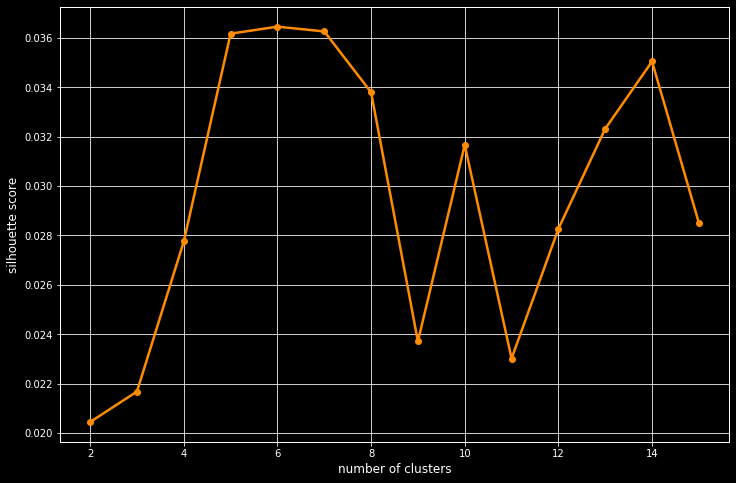

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(2,maxk), silhouette[2:maxk], 'o-', linewidth=2.5, color="darkorange")
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")

In [42]:
plt.style.use("dark_background")

In [52]:
# Okay, let's run with 14 clusters for now

In [53]:
# 4e. Max features but 14 topics:
vectorizer = TfidfVectorizer(strip_accents="ascii",
                             lowercase=True,
                             tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_,
                             max_features=None
                            )

X = vectorizer.fit_transform(combined_master_df["super_blob"])
features = vectorizer.get_feature_names()

kmeans_clusterer = KMeans(n_clusters=14,
                          n_jobs=-1
                     )

kmeans_clusterer.fit(X)
centroid_array = kmeans_clusterer.cluster_centers_
top_centroids = centroid_array.argsort()[:, -1:-11:-1]

print("Top 10 words for each cluster:\n")
for num, centroid in enumerate(top_centroids):
    print(f"Centroid {num} :",", ".join(features[i] for i in centroid),"\n")

Top 10 words for each cluster:

Centroid 0 : dukat, sisko, garak, cardassian, kira, episode, eddington, gul, cardassians, dominion 

Centroid 1 : kirk, spock, episode, enterprise, mccoy, one, planet, trek, star, like 

Centroid 2 : data, episode, riker, enterprise, picard, troi, one, geordi, ship, star 

Centroid 3 : borg, seven, voyager, janeway, collective, episode, nine, queen, doctor, drones 

Centroid 4 : archer, pol, enterprise, trip, episode, phlox, vulcans, vulcan, hoshi, reed 

Centroid 5 : worf, klingon, klingons, alexander, episode, martok, kurn, gowron, jadzia, kor 

Centroid 6 : quark, ferengi, nagus, rom, episode, grand, zek, one, ds9, brunt 

Centroid 7 : odo, kira, sisko, hadar, jake, episode, jem, station, quark, dominion 

Centroid 8 : voyager, janeway, episode, doctor, elanna, tom, b, one, crew, paris 

Centroid 9 : episode, bashir, dax, brien, sisko, jadzia, one, ds9, ezri, trill 

Centroid 10 : neelix, tuvok, voyager, kes, paris, episode, tuvix, jetrel, tom, lungs 

In [59]:
combined_master_df.head(1)

,ep_title,show_sea_ep,airdate,synopsis,IMDB_ID,IMDB_user_rating,num_IMDB_usr_rtgs,season,episode,series,year,rvr_rating,title_blob,rev_blob,super_blob
0,The Cage,Star Trek: The Original Series - Season 1 - 0,1988-11-27,Capt. Pike is held prisoner and tested by alie...,https://www.imdb.com/title/tt0059753,7.7,4631,1,0,TOS,1988,8.727273,'history in the making'\n 'Nice look into what...,'Just think...if Jeffrey Hunter had wound up p...,Capt. Pike is held prisoner and tested by alie...


In [67]:
print("Random sample of episodes in each cluster:\n")
assigned_cluster = kmeans_clusterer.transform(X).argmin(axis=1)
for i in range(kmeans_clusterer.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster==i]
    sample_ep_titles = np.random.choice(cluster, 5, replace=False)
    print("Cluster %d:" % i)
    for ep_title in sample_ep_titles:
        print(f'{combined_master_df.loc[ep_title]["series"]} S:{combined_master_df.loc[ep_title]["season"]}E:{combined_master_df.loc[ep_title]["season"]} {combined_master_df.loc[ep_title]["ep_title"]},  {combined_master_df.loc[ep_title]["IMDB_user_rating"]}')
              
              

Random sample of episodes in each cluster:

Cluster 0:
DS9 S:4E:4 Indiscretion,  7.8
DS9 S:3E:3 The Adversary,  8.3
DS9 S:7E:7 'Til Death Do Us Part,  7.7
DS9 S:2E:2 Second Sight,  6.2
DS9 S:2E:2 The Maquis: Part I,  7.9
Cluster 1:
TOS S:3E:3 Turnabout Intruder,  7.0
TOS S:1E:1 Shore Leave,  7.6
TAS S:1E:1 The Ambergris Element,  6.4
TOS S:1E:1 A Taste of Armageddon,  8.1
TOS S:2E:2 The Omega Glory,  6.2
Cluster 2:
TNG S:5E:5 Disaster,  8.0
TNG S:6E:6 Frame of Mind,  8.3
TNG S:6E:6 True Q,  7.5
TNG S:1E:1 Hide and Q,  7.0
TNG S:2E:2 The Schizoid Man,  7.0
Cluster 3:
VOY S:4E:4 Hope and Fear,  8.2
VOY S:4E:4 The Raven,  7.6
VOY S:6E:6 Unimatrix Zero,  8.1
VOY S:6E:6 The Voyager Conspiracy,  7.6
VOY S:5E:5 Bliss,  7.8
Cluster 4:
ENT S:1E:1 Fight or Flight,  7.1
ENT S:4E:4 United,  8.6
ENT S:2E:2 Future Tense,  8.3
ENT S:4E:4 The Augments,  8.2
ENT S:1E:1 Vox Sola,  6.9
Cluster 5:
TNG S:5E:5 Redemption II,  8.5
TNG S:5E:5 Ethics,  7.3
TNG S:7E:7 Parallels,  8.9
TNG S:6E:6 Birthright: Part